In [56]:
%matplotlib inline
import numpy as np
from sklearn.naive_bayes import GaussianNB
np.set_printoptions(precision=3, suppress=True)

In [48]:
class LDA:
    labels = None
    coeff = None
    eig_vecs, eig_vals = None, None
    classifier = None
    
    def fit(self, X, y):
        # Implemented from Pattern Classification by Richard O. Duda, 
        # Peter E. Hart  and DAvid G. Stork pg 121 Multiple Discriminant Analysis
        self.labels = np.unique(y).astype(int)
        num_classes = self.labels.size
        num_feat = X.shape[1]
        
        m = X.mean(axis=0)
        
        St = np.cov((X - m).T)
        Sb = np.empty((num_classes, num_feat, num_feat))
        mi = np.empty((num_classes, num_feat))
        
        ni = np.bincount(y)[self.labels]
        
        for index, label in enumerate(self.labels):
            mi[index] = X[y == label].mean(axis=0)
            Sb[index] = ni[index] * np.cov(X[y == label].mean(axis=0).T - m.T)
        Sb = Sb.sum(axis=0)
        Sw = St - Sb
        w = np.linalg.pinv(Sw) @ (mi[0] - mi[1]).T
        self.coeff = w
        self.eig_vals, self.eig_vecs = np.linalg.eigh(np.linalg.pinv(Sw) @ Sb)
        X_recon = np.dot(self.coeff, X.T).reshape(-1, 1)
        self.classifier = GaussianNB()
        self.classifier.fit(X_recon, y)
        
    def predict(self, X):
        X_recon = np.dot(self.coeff, X.T).reshape(-1, 1)
        return self.classifier.predict(X_recon)

In [4]:
def sample_mask_from(bool_array, sample_size):
    sample_rows_mask = bool_array.copy()
    temp = bool_array[bool_array == True]
    temp[sample_size:] = False
    np.random.shuffle(temp)
    sample_rows_mask[sample_rows_mask == True] = temp
    return sample_rows_mask

In [5]:
wine_data = np.genfromtxt('../Data/wine.data', delimiter=',')
rows_1 = (wine_data[:,0] == 1)
rows_2 = (wine_data[:,0] == 2)
wine_data = wine_data[rows_1 + rows_2]
rows_1 = (wine_data[:,0] == 1)
rows_2 = (wine_data[:,0] == 2)
five_sample_rows_mask = sample_mask_from(rows_1, 5) + sample_mask_from(rows_2, 5)
train_set_1 = wine_data[five_sample_rows_mask]
test_set_1 = wine_data[~five_sample_rows_mask]

fifty_sample_rows_mask = sample_mask_from(rows_1, 50) + sample_mask_from(rows_2, 50)
train_set_2 = wine_data[fifty_sample_rows_mask]
test_set_2 = wine_data[~fifty_sample_rows_mask]

Fit data

In [11]:
lda_1, lda_2 = LDA(), LDA()
lda_1.fit(train_set_1[:, 1:], train_set_1[:, 0].astype(int))
lda_2.fit(train_set_2[:, 1:], train_set_2[:, 0].astype(int))

Predict labels

In [12]:
w_pred_lab_1, w_pred_lab_2 = lda_1.predict(test_set_1[:, 1:]), lda_2.predict(test_set_2[:, 1:])

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd

Evaluate model performance

Wine Data:

For five samples

    Confusion Matrix

In [14]:
pd.DataFrame(confusion_matrix(test_set_1[:, 0], w_pred_lab_1), columns=['Class 1', 'Class 2'], index = ['Class 1', 'Class 2'])

,Class 1,Class 2
Class 1,42,12
Class 2,10,56


For fifty samples

In [16]:
pd.DataFrame(confusion_matrix(test_set_2[:, 0], w_pred_lab_2), columns=['Class 1', 'Class 2'], index = ['Class 1', 'Class 2'])

,Class 1,Class 2
Class 1,9,0
Class 2,0,21


    Accuracy Score

For five samples

In [25]:
print("Accuracy is: {:.3}%".format(accuracy_score(test_set_1[:, 0], w_pred_lab_1, normalize=True) * 100))

Accuracy is: 81.7%


For fifty samples

In [27]:
target_names = ['Class 1', 'Class 2']
print(classification_report(test_set_1[:, 0], w_pred_lab_1, target_names=target_names))

             precision    recall  f1-score   support

    Class 1       0.81      0.78      0.79        54
    Class 2       0.82      0.85      0.84        66

avg / total       0.82      0.82      0.82       120



For fifty samples

    Confusion matrix

In [21]:
pd.DataFrame(confusion_matrix(test_set_2[:, 0], w_pred_lab_2), columns=['Class 1', 'Class 2'], index = ['Class 1', 'Class 2'])

,Class 1,Class 2
Class 1,9,0
Class 2,0,21


    Accuracy Score

In [26]:
print("Accuracy is: {:.4}%".format(accuracy_score(test_set_2[:, 0], w_pred_lab_2, normalize=True) * 100))

Accuracy is: 100.0%


In [28]:
print(classification_report(test_set_2[:, 0], w_pred_lab_2, target_names=target_names))

             precision    recall  f1-score   support

    Class 1       1.00      1.00      1.00         9
    Class 2       1.00      1.00      1.00        21

avg / total       1.00      1.00      1.00        30



K fold cross validation

In [29]:
from sklearn.cross_validation import StratifiedKFold

In [30]:
num_folds = 10
skf = StratifiedKFold(wine_data[:, 0], n_folds=num_folds, shuffle=True)
X = wine_data[:, 1:]
y = wine_data[:, 0]

In [32]:
accuracy_scores = []
for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LDA()
    clf.fit(X_train, y_train.astype(int))
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test.astype(int), y_pred))

Average accuracy from cross validation is

In [35]:
print("Accuracy is: {:.4} %".format(np.asarray(accuracy_scores).mean()*100))

Accuracy is: 98.46 %


# MNIST Data

Load MNIST Data

In [36]:
mnist_data = np.genfromtxt('../Data/MNIST_HW1/train.csv', delimiter=',', dtype=np.float)
mnist_data = mnist_data.T
X = mnist_data[:, :-1]
y = mnist_data[:, -1].astype(int)
# Select data corresponding to 0 and 1 digits
rows_0_1 = ((y == 0) + (y == 1))
# Select data corresponding to 3 and 5 digits
rows_3_5 = ((y == 3) + (y == 5))
X_0_1 = X[rows_0_1]
X_3_5 = X[rows_3_5]
y_0_1 = y[rows_0_1].astype(int)
y_3_5 = y[rows_3_5].astype(int)

Fit to model

In [49]:
lda_01, lda_35 = LDA(), LDA()
lda_01.fit(X_0_1, y_0_1)
lda_35.fit(X_3_5, y_3_5)

Load MNIST Test Data

In [40]:
mnist_test_data = np.genfromtxt('../Data/MNIST_HW1/test.csv', delimiter=',', dtype=np.float)
mnist_test_data = mnist_test_data.T
X_test = mnist_test_data[:, :-1]
y_test = mnist_test_data[:, -1].astype(int)
# Select data corresponding to 0 and 1 digits
rows_0_1 = ((y_test == 0) + (y_test == 1))
# Select data corresponding to 3 and 5 digits
rows_3_5 = ((y_test == 3) + (y_test == 5))
X_test_0_1 = X_test[rows_0_1]
X_test_3_5 = X_test[rows_3_5]
y_test_0_1 = y_test[rows_0_1]
y_test_3_5 = y_test[rows_3_5]

Get predictions

In [50]:
y_pred_0_1 = lda_01.predict(X_test_0_1)
y_pred_3_5 = lda_35.predict(X_test_3_5)

Evaluate model performance

    Confusion matrix

        0 1 labels

In [51]:
pd.DataFrame(confusion_matrix(y_test_0_1, y_pred_0_1), columns=['Digit 0', 'Digit 1'], index = ['Digit 0', 'Digit 1'])

,Digit 0,Digit 1
Digit 0,976,4
Digit 1,12,1123


        3 5 labels

In [52]:
pd.DataFrame(confusion_matrix(y_test_3_5, y_pred_3_5), columns=['Digit 0', 'Digit 1'], index = ['Digit 0', 'Digit 1'])

,Digit 0,Digit 1
Digit 0,985,25
Digit 1,41,851


    Accuracy score

        0 1 digits

In [53]:
print("Accuracy is: {:.4}%".format(accuracy_score(y_test_0_1, y_pred_0_1, normalize=True) * 100))

Accuracy is: 99.24%


        3 5 digits

In [54]:
print("Accuracy is: {:.4}%".format(accuracy_score(y_test_3_5, y_pred_3_5, normalize=True) * 100))

Accuracy is: 96.53%


# LDA for dimensionality reduction

In [57]:
import matplotlib.pyplot as plt

Cumulative Eigen Values

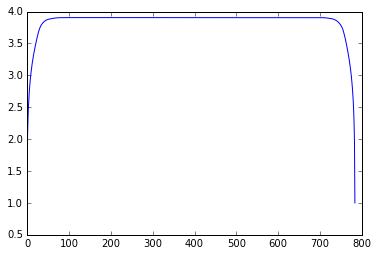

In [64]:
plt.plot(lda_01.eig_vals.cumsum()/lda_01.eig_vals.sum())

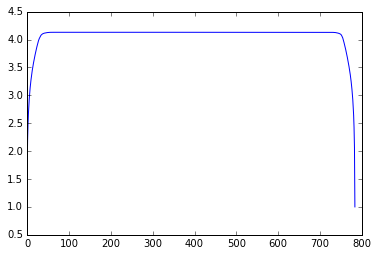

In [65]:
plt.plot(lda_35.eig_vals.cumsum()/lda_35.eig_vals.sum())

Display Eigen Vectors

In [66]:
import scipy as sp
from scipy.misc import toimage, imresize

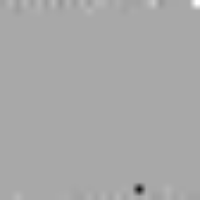

In [67]:
toimage(imresize(lda_01.eig_vecs[0].reshape(28, 28), size=(200, 200)))

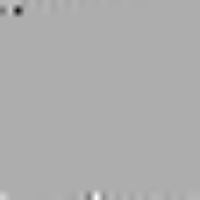

In [68]:
toimage(imresize(lda_35.eig_vecs[0].reshape(28, 28), size=(200, 200)))